In [27]:
# importing all the required libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import scipy.stats
import matplotlib.dates as mdates
import plotly.graph_objects as go
plt.style.use('bmh')

<code style="background:pink; color:black"> Cells with blue background represent the questions from _data/ultimate_data_science_challenge.pdf_ and the solution follows that cell. Obervations/Conclusions can be found in the green colored cells.</code>

<div class="alert alert-block alert-info">

    
## Part 1 ‑ Exploratory data analysis  

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.
    </div>

In [19]:
# Importing the json file into a dataframe

# load as Pandas dataframe
logins = pd.read_json('data/logins.json' )
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [20]:
# setting the logins datetime as index and adding a new column for counting the number of logins 
logins.set_index('login_time', inplace = True)
logins['count'] = 1

In [22]:
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [23]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
count    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


__Defining some functions__

In [63]:
def plot_ts(ts, title = 'time series', opacity = 1):
    """
    Plot plotly time series of any given timeseries ts
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "logins",
                         line_color = 'royalblue', opacity = opacity)) #lightslategrey

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True, 
                  yaxis_title="count of logins")
    fig.show()
    
    
def resample_logins(df, time_interval = '15T'):
    return df.resample(time_interval).sum()

In [67]:
logins_15mts = resample_logins(logins, '15T')
logins_hourly = resample_logins(logins, 'H')
logins_daily = resample_logins(logins, 'D')
logins_monthly = resample_logins(logins, 'M')

In [65]:
logins_15mts.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [66]:
print("the number of null values in the dataframe are: ", logins_15mts.isna().sum())

the number of null values in the dataframe are:  count    0
dtype: int64


In [77]:
# PLotting the 15mts resampled dataset
for ts in ['15T', 'H', 'D', 'M']:
    plot_ts(resample_logins(logins, ts)['count'], title = 'Plotting logins at '+ ts + ' interval', opacity = 1)


<div class="span5 alert alert-success">
<h3>Observations</h3>

Let's plot aggregated plots to further verify the daily and weekly periodicity observed from the above time series plots.

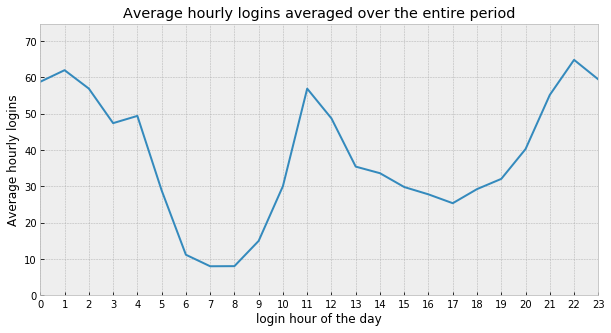

In [130]:
# Observing daily cycle of the logins

logins_hourly.groupby(logins_hourly.index.hour)['count'].mean().plot(figsize = (10,5))
_ = plt.ylabel('Average hourly logins')
_ = plt.xlabel('login hour of the day')
_ = plt.ylim([0, max(logins_hourly.groupby(logins_hourly.index.hour)['count'].mean()) + 10])
_ = plt.xticks(logins_hourly.index.hour.unique())
_ = plt.title('Average hourly logins averaged over the entire period')

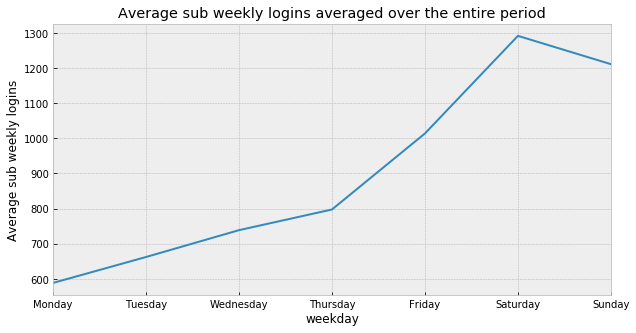

In [131]:
# PLotting weekly cycle of the logins dataset

sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))

df_weekly = logins_daily.groupby(logins_daily.index.weekday_name).mean()
df_weekly['Day_id'] = df_weekly.index
df_weekly['Day_id'] = df_weekly['Day_id'].map(sorterIndex)
df_weekly.sort_values('Day_id', inplace=True)

df_weekly['count'].plot(figsize = (10,5))
_ = plt.xticks([x for x in df_weekly.Day_id])
_ = plt.ylabel('Average sub weekly logins')
_ = plt.xlabel('weekday')
_ = plt.title('Average sub weekly logins averaged over the entire period')

<div class="span5 alert alert-success">
<h3>Observations</h3>

- Based on the above plots it is observed that the number of logins are cyclical and they have two peaks during a day, one at around 12am and another at around 12pm. 
- The number of logins also has a weekly periodicity where the number of logins are higher during the weekends compared to the weekdays.
- The overall number of logins has increased over the months (the April drop should be ignored because the data only contains 

___

<div class="alert alert-block alert-info">

    
## Part 2 ‑ Experiment and metrics design  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:  
    a. how you will implement the experiment  
    b. what statistical test(s) you will conduct to verify the significance of the observation  
    c. how you would interpret the results and provide recommendations to the city  
    </div>

<div class="span5 alert alert-success">
<h3>Answer</h3>
    
Assumptions: Driving partners referred to here are drivers who drive for the ride sharing company. 
 
1. A key measure of success can be the increased activity on the app or increased driver trips after the toll reimbursements. 
    
    Note: From economics point of view a key measure of success can also be the added revenue to the Ultimate technolgies account from drivers (who weren't crossing cities before) of one city picking up rides in another city OR doing inter-city rides. One example would be - if during the night time, the not-so-active Metropolis drivers cross the toll bridge (because it is free) to Gotham city and generate enough revenue to surpass the toll reimbursements then it should be considered as a success.  
    
    
2. I'd perform a A/B test where the control group would be drivers who will not be reimbursed for the tolls and the treatment group will be drivers who will be reimbursed for the tolls.  

    a. We can compare the number of treatment drivers crossing the toll bridge with the number of control drivers crossing the toll bridge.  

    b. Since sample size is expected to be large here we can perform a z-test. The null hypothesis can be that the number of drivers crossing the toll bridge doesn't get affected by toll reimbursement.  

    c. Critical z-statistic can be computed and compared against the difference between the number of treatment and control drivers. If number of treament drivers > number of control drivers crossing the bridge and the p-value is <0.05 then we can reject the null hypothesis and state the result as significant. 

    If that's the case, we can implement the toll reimbursement to increase Ultimate's activity in both the cities. 

<div class="alert alert-block alert-info">
    
## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).